#Introduction

In this notebook, we will investigate different methods of image classification with CNN. First, we will create a CNN model based on 'Alexnet' architecture proposed in 2014 [paper](https://arxiv.org/pdf/1404.5997.pdf) of Alex Krizhevsky. We will train and evaluate the model from scratch with the data that we have. Secondly, we will obtain the same architecture as a pre-trained model from the 'torchvision' library. we will compare the results between the model from scratch and the pre-trained model. But before all that, since the project will work on Google Drive Environment, we will mount to Drive in order to obtain the data.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Necessary imports

In [ ]:
import os
import re
import glob
import json
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, random_split

from google.colab.patches import cv2_imshow

A magic command to locate folders easily

In [ ]:
%cd /content/drive/My Drive/IYTE/CENG 506 (Deep Learning)/Project

/content/drive/My Drive/IYTE/CENG 506 (Deep Learning)/Project


#Data

Data for the project located at '/Project/data' direction and consist of 4 folders named after the classes of the images. There are total 1400 animal images separated in 4 folders being ["bear", "elephant", "leopard", "zebra"]. First, we will read the file locations and label then as the folder name suggests. We will then save this relation as .csv file so whenever we want, input images and their labels will be at hand.

We will have text labels for images such as 'bear' however, this label is meaningless for CNN so that we will create a dictionary to map string labels to integers. Thus, we will use the integer labels but still can print string labels at will.

In [ ]:
classes = ["bear", "elephant", "leopard", "zebra"]
label2id = {c : i for i,c in enumerate(classes)}
id2label = {i : c for i,c in enumerate(classes)}
print("bear:{}, eleplant:{}, leopard:{} zebra:{}".format(label2id["bear"], label2id["elephant"], label2id["leopard"], label2id["zebra"]))

bear:0, eleplant:1, leopard:2 zebra:3


We read all folder and files under './data' directory and save their directory to a Pandas DataFrame along with their folder names corresponding label value.

In [ ]:
data = pd.DataFrame([[file, label2id[re.sub("./data/","",os.path.dirname(file))] ] for file in glob.glob("./data/*/*.JPEG")],columns=["file", "label"])
data.to_csv("./data/data.csv", index=None)

Now, we can read image-label data easily from 'data.csv' file

In [ ]:
df = pd.read_csv("./data/data.csv")
df

,file,label
0,./data/elephant/n02504458_10515.JPEG,1
1,./data/elephant/n02504458_11382.JPEG,1
2,./data/elephant/n02504458_10428.JPEG,1
3,./data/elephant/n02504458_11260.JPEG,1
4,./data/elephant/n02504458_12449.JPEG,1
...,...,...
1395,./data/zebra/n02391049_857.JPEG,3
1396,./data/zebra/n02391049_7648.JPEG,3
1397,./data/zebra/n02391049_796.JPEG,3
1398,./data/zebra/n02391049_879.JPEG,3


Before starting anything with CNN. We might have a look at the data for ensuring it is loaded successfully and to have an idea of its properties. 

Just a quick check to the data: Making sure that there is no Null cell and the data has an acceptable class distribution.

There are 350 images for every class.

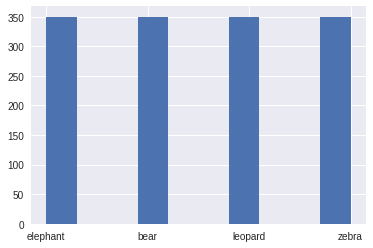

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    1400 non-null   object
 1   label   1400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.0+ KB
None


In [ ]:
plt.hist(df.label.apply(lambda x: id2label[x]))
plt.show()
print(df.info())

Random examples from the data. As we can see, image size varies and we need to deal with this along with the other transformation operations (such as resize and normalization).

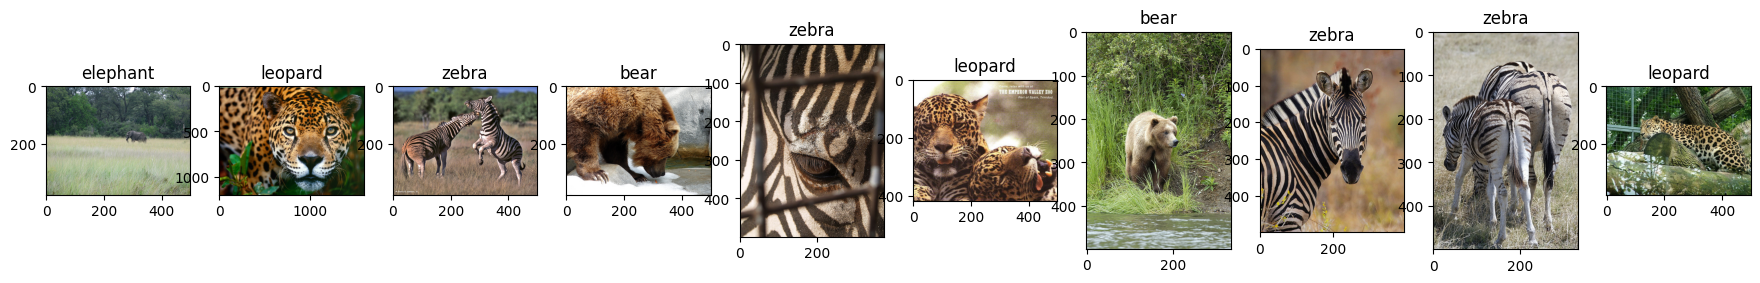

In [ ]:
mpl.style.use('default')
fig=plt.figure(figsize=(22, 8))
for i in range(1, 11):
  index = np.random.randint(df.shape[0])
  img = Image.open(df.file[index])
  fig.add_subplot(1, 10, i)
  plt.title(id2label[df.label[index]])
  plt.imshow(img)

Lastly, We define a custom DataSet object to feed the model with DataLoaders. This will allow us to use shuffle and data batches much easily since it works with Pytorch 

In [ ]:
class custom_dataset(Dataset):
  def __init__(self, data, transform=None):
    self.transform = transform

    self.images = np.array(data.file)
    self.labels = np.array(data.label)

  def __getitem__(self, idx):
    img = Image.open(self.images[idx])
    if self.transform:
      img = self.transform(img)
    
    return img, self.labels[idx]
  
  def __len__(self):
    return len(self.labels)

#Creating the CNN Architecture


##Parameters

We define the parameter dictionary in order to simply manage hyperparameters and perform parameter searches. Below it can be seen that initial parameters are mostly default values or common uses of those parameters. We will test our model with these parameters once it's ready to perform.

In [ ]:
#initial parameters
params = {
    "input_dim": 224,
    "input_channel": 3,
    "output_dim": 4,
    "partitions": [int(round(len(df) * 0.8 )), int(round(len(df)* 0.1 )), int(round(len(df)* 0.1 ))], #we have three partition being train, validation and test
    "epochs": 50,
    "batch_size": 32,
    "num_workers":8,
    "lr": 1e-3,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "dropout_reg": 0.5, #dropdown value
    "weight_decay": 1e-3,
}
transform = transforms.Compose([transforms.Resize(params["input_dim"]), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

params["transform"] = transform

##Model
We will define the model as 'nn. Module' inheritance. This class will have the almost exact same structure as 'AlexNet'. Just some little adjustments have been done in order to fit our data.

In [ ]:
class Net(nn.Module):
    def __init__(self, params, batch_size=None, num_workers=None, epochs=None, lr=None, reg=None, partitions=None, weight_decay=None):
        super(Net, self).__init__ ()

        self.device = params["device"]
        self.batch_size = params["batch_size"] if batch_size is None else batch_size 
        self.num_workers = params["num_workers"] if num_workers is None else num_workers
        self.epochs = params["epochs"] if epochs is None else epochs
        self.lr = params["lr"] if lr is None else lr
        self.reg = params["dropout_reg"] if reg is None else reg
        self.weight_decay = params["weight_decay"] if weight_decay is None else weight_decay
        
        self.transform = params["transform"]
        self.partitions = params["partitions"] if partitions is None else partitions
        
        self.input_dim = params["input_dim"]
        self.input_channel = params["input_channel"]
        self.output_dim = params["output_dim"]

        self.conv_base = nn.Sequential(
            nn.Conv2d(self.input_channel, 96, kernel_size=11, stride=4, padding=2, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc_base = nn.Sequential(
            nn.Dropout(p= self.reg),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p= self.reg),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True,),
            
            nn.Linear(4096, self.output_dim),
        )

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr , weight_decay=self.weight_decay)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', verbose=True)
        self.to(self.device)

    def data_prep(self, data):
      data = custom_dataset(data, transform=self.transform)
      train_set, val_set, test_set = random_split(data, self.partitions)
      self.train_count, self.val_count, self.test_count =  len(train_set), len(val_set), len(test_set)
      self.train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
      self.val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
      self.test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def foward(self, x):
      x = self.conv_base(x)
      x = x.view(x.size(0), -1)
      x = self.fc_base(x)
      return x

    def _train(self):
      print("Training Started. {} Epochs to go".format(self.epochs))
      train_loss = []
      t_acc = []

      validation_loss = []
      v_acc = []

      for epoch in range(self.epochs):

        #----------------Train phase
        self.train()
        t_running_loss = 0
        t_running_acc = 0
        for t_batch, (inputs, labels) in enumerate(self.train_loader):
          inputs, labels = inputs.to(self.device), labels.to(self.device)
          self.optimizer.zero_grad()
          outputs = self.foward(inputs)
          t_loss = self.loss(outputs, labels)
          _, t_preds = torch.max(outputs, 1)
          t_running_loss += t_loss.item()
          t_running_acc += torch.sum(torch.eq(labels, t_preds)).item()
          t_loss.backward()
          self.optimizer.step()
        train_loss.append(t_running_loss/(t_batch+1))
        t_acc.append(t_running_acc/self.train_count)

        #----------------Validation phase
        self.eval()
        v_running_loss = 0
        v_running_acc = 0
        for v_batch, (inputs, labels) in enumerate(self.val_loader):
          inputs, labels = inputs.to(self.device), labels.to(self.device)
          outputs = self.foward(inputs)
          v_loss = self.loss(outputs, labels)
          _, v_preds = torch.max(outputs, 1)
          v_running_loss += v_loss.item()
          v_running_acc += torch.sum(torch.eq(labels, v_preds)).item()
        self.scheduler.step(v_loss.item())
        validation_loss.append(v_running_loss/(v_batch+1))
        v_acc.append(v_running_acc/self.val_count)

        print("Epoch:{}///// Train Loss:{} ----- Validation Loss:{} ///// Train Acc:{} ----- Validation Acc:{}".format(epoch, t_running_loss/(t_batch+1), v_running_loss/(v_batch+1), t_running_acc/self.train_count, v_running_acc/self.val_count ))
      print("/////Training Finished/////")
      print("\n")
      print("\n")
      return train_loss, t_acc, validation_loss, v_acc  

    def test(self):
      self.eval()
      running_loss = 0
      running_acc = 0
      labels_list = []
      predictions_list = []

      for batch, (inputs, labels) in enumerate(self.test_loader):
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        labels_list.extend(labels.cpu().numpy())
        outputs = self.foward(inputs)

        loss = self.loss(outputs, labels)
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        predictions_list.extend(preds.cpu().numpy())
        running_acc += torch.sum(torch.eq(labels, preds)).item()
      print("Test Accuracy:{}".format(running_acc/self.test_count))
      return running_acc/self.test_count


In [ ]:
Net(params)

Net(
  (conv_base): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ce

## Model Investigation

A sanity check: We can **overfit** the model by using a small portion of the data and no regularization, almost perfectly. This indicates that the general structure of the pipeline is right and we can start tuning the hyperparameters.

In [ ]:
net = Net(params, reg=0, weight_decay=0,  partitions=[16,2,2], epochs=13)
net.data_prep(df.sample(20)) 
loss_values = net._train()

Training Started. 13 Epochs to go
Epoch:0///// Train Loss:1.4316046833992004 ----- Validation Loss:1.404350757598877 ///// Train Acc:0.1875 ----- Validation Acc:0.0
Epoch:1///// Train Loss:1.283236175775528 ----- Validation Loss:1.4727416038513184 ///// Train Acc:0.3125 ----- Validation Acc:0.0
Epoch:2///// Train Loss:1.0547944158315659 ----- Validation Loss:1.769648790359497 ///// Train Acc:0.625 ----- Validation Acc:0.0
Epoch:3///// Train Loss:0.8899383991956711 ----- Validation Loss:2.6043803691864014 ///// Train Acc:0.5625 ----- Validation Acc:0.0
Epoch:4///// Train Loss:0.716663733124733 ----- Validation Loss:2.942009687423706 ///// Train Acc:0.625 ----- Validation Acc:0.0
Epoch:5///// Train Loss:0.614634782075882 ----- Validation Loss:2.5942070484161377 ///// Train Acc:0.625 ----- Validation Acc:0.0
Epoch:6///// Train Loss:0.5153327658772469 ----- Validation Loss:3.288794994354248 ///// Train Acc:0.8125 ----- Validation Acc:0.0
Epoch:7///// Train Loss:0.5291854962706566 ----- Val

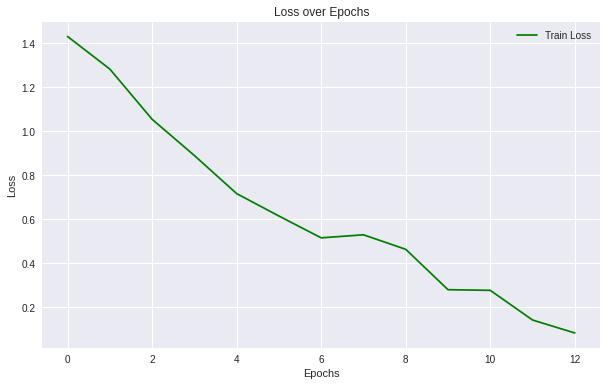

In [ ]:
count = len(loss_values[0])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
#plt.xticks(range(0,count))
#plt.yticks(np.arange(0,10,0.1))
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(range(0,count), loss_values[0], color='green', label='Train Loss')
plt.legend()
plt.savefig('./result/Overfitting the model with small data.png')

As another sanity check, we will run our test phase without even training. Just to check the model structure. This test operation will not have any affect on the model since it resets its parameters with the begining of every training.

Raw test result have 0.25 accuracy. This value is confidently correct since we have 4 classes and haven't done any training yet. Model just randomly picks any of the 4 values. 

In [ ]:
net = Net(params)
net.data_prep(df)
result = net.test()

Tested with 140 images/// Loss:1.3852471283503942 ----- Accuracy:0.2571428571428571


##Training and Validation

Since we are now confident with the model structure. There will be a first attempt of train and validation of the model. Using mostly default parameters. 

As seen in the graph below, the model gave good results for test but bad results for validation. It was good at the begining, however around 18th epoch validation loss suddenly inceased and never decreased again. This is the sign of overfitting. We will tune the hyper parameters to prevent this problem.

In [ ]:
net = Net(params)
net.data_prep(df)
loss_values = net._train()

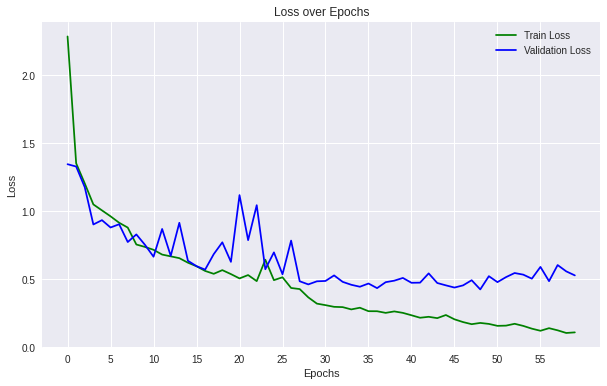

In [ ]:
count = len(loss_values[0])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.xticks(range(0,count,5))
#plt.yticks(np.arange(0,10,0.1))
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(range(0,count), loss_values[0], color='green', label='Train Loss')
plt.plot(range(0,count), loss_values[2], color='blue', label='Validation Loss')
plt.legend()
plt.savefig('./result/First Attempt with default parameters - Overfits after 18th epoch.png')

There might be a few main reasons for overfitting:

1) Not enough data. There are only 1400 images in total and only 70% of it is used for training. To deal with overfitting, the number of training images might be increased by giving away a percentage of test and validation data using or data augmentation.
Not enough regularization/generalization. The model uses L2 weight decay as 0.0001and dropout probability as 0.5. These values can be increased for the model to have a more generalized understanding of the training data.

2) Apart from these, the implementation has many more aspects to improve in order to overcome the overfitting results; such as having a simpler model architecture or having different filter and fully connected dimensions. However, for this project, the stated 2 main reasons will be taken into account priorly.

Apart from the dropout rate and regularization, there are more parameters that can affect the training and validation results. It would be too complicated to tune them all manually since every different combination would have a different effect on the results and it is hard to see the full potential of the model without trying many different combinations. All possible parameter combinations (that are in their target range) can be tested using the grid-search method. However, the random search method will be used instead over the grid-search. Considering the parameters and their scales, grid-search would be too costly (900 total runs) to implement since there are many combinations and the number of combinations grows exponentially with the number of parameters.

## Hyper-Parameter Tuning

We define a random search and a random parameter generator. We will compute over random parameters many times and investigate the results to pick optimum parameters for our case. We will not tune every parameter, but only the training/validation performence affective ones. For this case these parameters would be; Weight decay, dropout regularization constant, learning rate, batch size and epochs. We defined a few possible values in a certain range for each of the parameters considering their common values.

In [ ]:
def generate_random_params():

  #parameters to be searched
  weight_decay = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
  dropout_reg = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
  lr = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5]
  batch_size = [4, 8, 16, 32, 64, 128]
  epochs = [40, 50, 60]

  params = {
    "input_dim": 256,
    "input_channel": 3,
    "output_dim": 4,
    "partitions": [int(round(len(df) * 0.8 )), int(round(len(df)* 0.1 )), int(round(len(df)* 0.1 ))], #training partition has been increased to 0.8.
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "num_workers":8,

    "epochs": epochs[np.random.randint(len(epochs))],
    "batch_size": batch_size[np.random.randint(len(batch_size))],
    "lr": lr[np.random.randint(len(lr))],
    "dropout_reg": dropout_reg[np.random.randint(len(dropout_reg))], 
    "weight_decay": weight_decay[np.random.randint(len(weight_decay))],
  }
  transform = transforms.Compose([transforms.Resize(params["input_dim"]), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  params["transform"] = transform
  return params


In [ ]:
def random_search(count):
  search_report = pd.DataFrame(columns=["params", "train_loss", "train_acc", "validation_loss", "validation_acc", "test_loss", "test_acc" ])
  for i in range(count):
    params = generate_random_params()
    net = Net(params)
    net.data_prep(df)
    train_loss, train_acc, validation_loss, validation_acc = net._train()
    test_loss, test_acc = net.test()
    train_loss, train_acc, validation_loss, validation_acc, test_loss, test_acc = random_gen()
    search_report.loc[i] = [params, train_loss, train_acc, validation_loss, validation_acc, test_loss, test_acc]
  return search_report

For a begining we will perform 20 random search operations. For each process will run for every epoch and save the last results along with the corresponding parametes in a DataFrame. After investigating the result, if a suitable set of parameters be found, we will further test those parameters individually in order to obtain the running loss and accuracy values for each epoch.

In [ ]:
search_report = random_search(20)

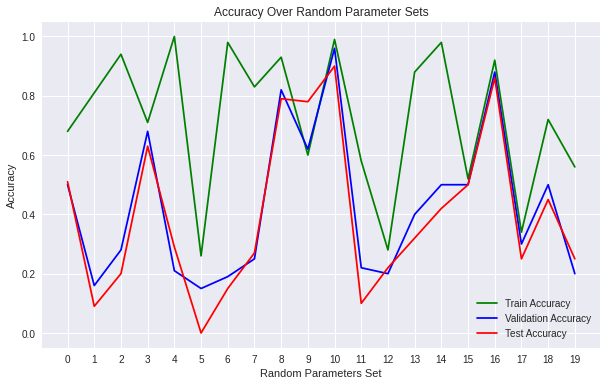

In [ ]:
count = search_report.shape[0]
plt.xlabel("Random Parameters Set")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Random Parameter Sets")
plt.xticks(range(0,count))
#plt.yticks(np.arange(0,10,0.1))
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(range(0,count), search_report.train_acc, color='green', label='Train Accuracy')
plt.plot(range(0,count), search_report.validation_acc , color='blue', label='Validation Accuracy')
plt.plot(range(0,count), search_report.test_acc , color='red', label='Test Accuracy')
plt.legend()
plt.savefig('./result/Accuracy Over Random Parameter Sets.png')

Tenth iteration results seems promising. We will further investigate the results.

In [ ]:
search_report.loc[10]

params             {'input_dim': 256, 'input_channel': 3, 'output...
train_loss                                                   0.03123
train_acc                                                    0.99196
validation_loss                                              0.18052
validation_acc                                                0.9643
test_loss                                                    0.39078
test_acc                                                         0.9
Name: 10, dtype: object

These are parameters that gives test results as 0.9. We will once again run the model with below parameters. If this last run found to be successfull, we will save the trained model with these parameters.

In [ ]:
search_report.loc[10].params

{'batch_size': 4,
 'device': 'cuda:0',
 'dropout_reg': 0.7,
 'epochs': 50,
 'input_channel': 3,
 'input_dim': 256,
 'lr': 0.0001,
 'num_workers': 8,
 'output_dim': 4,
 'partitions': [1120, 140, 140],
 'transform': Compose(
     Resize(size=256, interpolation=PIL.Image.BILINEAR)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
 ),
 'weight_decay': 0.01}

##Testing

We will test the model and save the results.

In [ ]:
#parameters from random_search.loc[10]

params = {
    "input_dim": 256,
    "input_channel": 3,
    "output_dim": 4,
    "partitions": [int(round(len(df) * 0.8 )), int(round(len(df)* 0.1 )), int(round(len(df)* 0.1 ))], #we have three partition being train, validation and test
    "epochs": 50,
    "batch_size": 4,
    "num_workers":8,
    "lr": 1e-4,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "dropout_reg": 0.7, #dropdown value
    "weight_decay": 1e-2,
}
transform = transforms.Compose([transforms.Resize(params["input_dim"]), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

params["transform"] = transform

Training the model with found parameters

In [ ]:
net = Net(params)
net.data_prep(df)
train_loss, t_acc, validation_loss, v_acc = net._train()

Training Started. 50 Epochs to go
Epoch:0///// Train Loss:1.1600121996232442 ----- Validation Loss:0.9801381958855523 ///// Train Acc:0.4142857142857143 ----- Validation Acc:0.4642857142857143
Epoch:1///// Train Loss:0.9928191789558956 ----- Validation Loss:0.8332094334893756 ///// Train Acc:0.5125 ----- Validation Acc:0.5071428571428571
Epoch:2///// Train Loss:0.9003360805766923 ----- Validation Loss:0.8170571294095781 ///// Train Acc:0.5901785714285714 ----- Validation Acc:0.6714285714285714
Epoch:3///// Train Loss:0.8825208314827511 ----- Validation Loss:0.6760757399929894 ///// Train Acc:0.5830357142857143 ----- Validation Acc:0.75
Epoch:4///// Train Loss:0.8053597326789583 ----- Validation Loss:0.7037496632999845 ///// Train Acc:0.6598214285714286 ----- Validation Acc:0.7214285714285714
Epoch:5///// Train Loss:0.6953219596828734 ----- Validation Loss:0.8287952078713311 ///// Train Acc:0.71875 ----- Validation Acc:0.6857142857142857
Epoch:6///// Train Loss:0.6820201764149325 ----- 

Results are olmost the same as those found in parameter search. Given that we randomly shuffle the data before each first training phase this is totally acceptable. Eventhoug the results are acceptable, roadmap to final epoch is quite spikey for validation loss. Validation loss is constantly decreasing however there are serius jumps and unstable points. Considering relatively small dataset that we have and number of epochs, this result is acceptable. Althoug a higher epoch count with even more regularization and more learning decay, this curve can be smoothened.

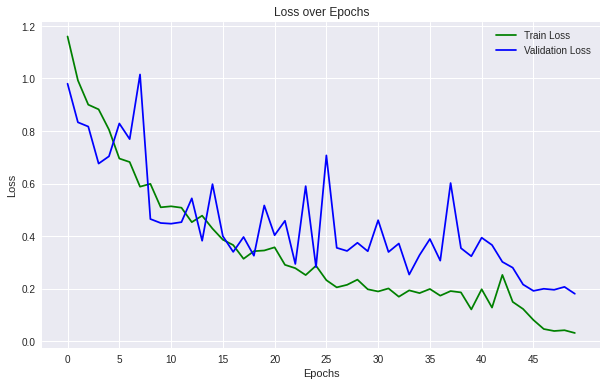

In [ ]:
count = len(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.xticks(range(0,count,5))
#plt.yticks(np.arange(0,10,0.1))
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(range(0,count), train_loss, color='green', label='Train Loss')
plt.plot(range(0,count), validation_loss, color='blue', label='Validation Loss')
plt.legend()
plt.savefig('./result/Successfull Run - Loss.png')

We see that accuracy values are similar to loss. Model ended up with 0.99 accuracy for taining and 0.96 accuracy for validation.

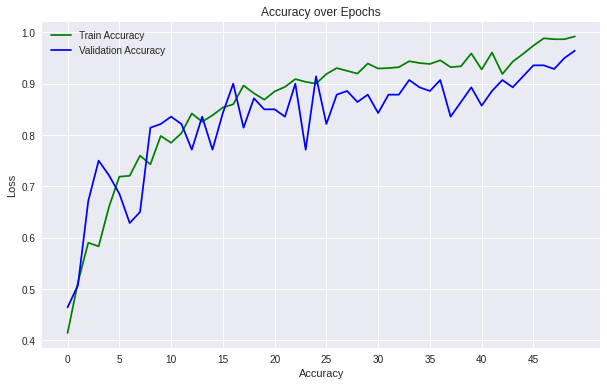

In [ ]:
count = len(t_acc)
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.title("Accuracy over Epochs")
plt.xticks(range(0,count,5))
#plt.yticks(np.arange(0,10,0.1))
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(range(0,count), t_acc, color='green', label='Train Accuracy')
plt.plot(range(0,count), v_acc, color='blue', label='Validation Accuracy')
plt.legend()
plt.savefig('./result/Successfull Run - Accuracy.png')

Lastly we see the test result and save the model with all the weights so we can easily use it again when needed.

In [ ]:
test_result = net.test()

Test Accuracy: 0.9


In [ ]:
torch.save(net.state_dict(), './model.pth')

In [ ]:
#Model Load
model = Net(params)
model_test.load_state_dict(torch.load("./model.pth"))

#Using Pre-Trained Model

Using the pretrained model is much more prectical than training one from scratch. This model is in fact 2012 ILSVRC winner with 15.3% error rate for top 5 classification for 1000 classes. Obviously harder task to achive considering we are only classification over 4 classes. This might one of the main reasons why our handcrafted model not seems to be failing at all.

##Loading

First, we download the pretrained model from torch library.

In [ ]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Testing

We will use the model as it is since our size of data is too small to have an affect on the model considering 1.2 million images of Alexnet, we only have 1400 images.

We will need to check the test results if the predictions matches the actual labels. For that, we must obtain models labels. Since Alexnet used Imagenet data, we will collect that. This class data may be found in [kaggle](https://www.kaggle.com/mhiro2/pytorch-pretrained-models?) or a more processed version in yrevars [github](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) page.

In [ ]:
alexnet_class_dict = json.load(open("./data/imagenet_class_index.json"))

Next we will create a dictionary that will act as a bridge between ourlabels and Imagenet labels. Instead, we could change our data labels as Imagenets however, it is more profitable to keep both structures as they are since it will make further testings simpler.

There are labeling differences between our data and Imagenet. For example, while we only have one general label as 'elephant', Imagenet has multiple labels for subdivisions of elephant classes. -Even only this situation revealing the relative simplicity of our task compared to alexnets competition.- Instead of 'elephant', Imagenet has two separate classes namely 'Indian elephant' and 'African elephant'. even though our data contains African Elephant images mostly, there are still considerable amount of Indian Elephant images and we wouldn't want penalty the model for a correct prediction according to its nature. The most efficient scenario would be relabeling the images as the model suggest however, we will consider this factor as out of the scope of this project. Thus, in this situation, we will accept both African and Indian Elephant labels as a prediction for elephant class.

In [ ]:
print("bear:{}, eleplant:{}, leopard:{} zebra:{}".format(label2id["bear"], label2id["elephant"], label2id["leopard"], label2id["zebra"]))

bear:0, eleplant:1, leopard:2 zebra:3


In [ ]:
model_label_dict = {
    294: 0, #brown bear
    386: 1, #african elephant
    385: 1, #indian elephant
    288: 2, #leopard
    340: 3 #zebra
}

This pretrained model is most suitable for 3x256x256 sized images as explained in the office Pytorch [site](https://pytorch.org/hub/pytorch_vision_alexnet/). We transform our data accourding to models needs such as mean and std values. These values are original mean and std values for Imagenet dataset which used for training this pretrained model.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

We are ready to perfom a test. We will iterate through the pandas DataFrame that contains images and their labels, make a prediction and mark if its correct or not. If the model predicts the image as none of our 4 classes, then models prediction is noted (for reporting porposes) in 'prediction_detail' column and prediction marked as '-1'

In [ ]:
def alexnet_test(df):
  test_result = pd.DataFrame(columns=["correct_label", "prediction", "conf", "prediction_detail", "error"])
  alexnet.eval()
  for i in range(df.shape[0]):
    img = Image.open(df.loc[i].file)
    img = transform(img)
    img = torch.unsqueeze(img, 0)
    predictions = alexnet(img)
    conf, index = torch.max(predictions, 1)

    correct_label = df.loc[i].label
    try:
      prediction = model_label_dict[index.item()]
    except:
      prediction = -1 

    error = 0 if prediction  == correct_label else 1
    test_result.loc[i] = [correct_label, prediction, conf.item(), index.item() , error ]
  return test_result

In [ ]:
result = alexnet_test(df)
print("Test Accuracy: ", (result[(result.error == 0)].shape[0]/result.shape[0]))

Test Accuracy:  0.7014285714285714


##Investigating Results

Test accuracy in fact lower than we would expected. Especially compared to the model from scratch results. We shall make further investigations on these results to indicate a cause of this result.

We can look at the error distribution among the result.

(array([ 40.,   0.,   0.,  50.,   0.,   0., 322.,   0.,   0.,   6.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

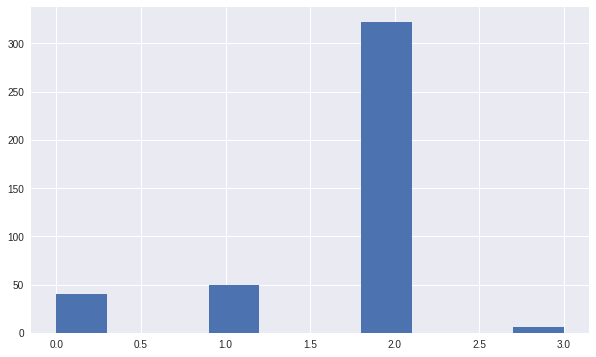

In [ ]:
plt.hist(result[(result.error == 1)].correct_label)

There is an obvius inbalance with the class id:2 which is 'leopard'. It is evident that most of the leopard images labeled wrong by the model. That means we should further investigate this portion of data to compensate the model accuracy.

We will look the disribution of models predictions for 'leopard' images. As mentioned 'prediction_detail column' will show us predictions that were wrong. In below chart there is an obvius spike for one class. This indicates that most of the leopard images mislabelled as such a specific label. We will list the most frequent values of this mislabeled set and investigate corresponding labels.

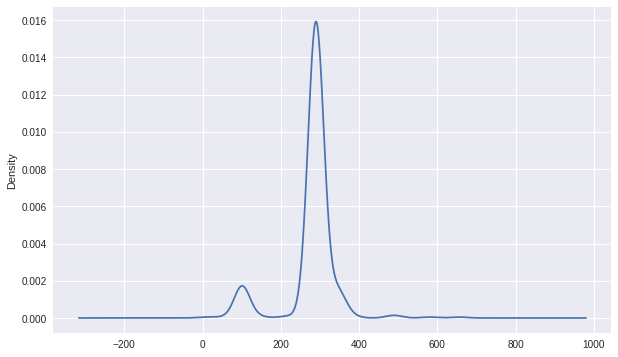

In [ ]:
result[(result.error == 1)].prediction_detail.plot.kde(bw_method=0.3)

Most frequent id is 290. Meaning that most of the leopard images mislabeled as 290 by the model.

In [ ]:
result[(result.error == 1)].prediction_detail.value_counts()

290.0    313
101.0     36
347.0      8
295.0      5
276.0      5
343.0      4
346.0      4
293.0      4
336.0      3
489.0      3
350.0      3
345.0      2
289.0      2
342.0      2
354.0      2
296.0      1
378.0      1
386.0      1
339.0      1
221.0      1
133.0      1
580.0      1
656.0      1
355.0      1
286.0      1
8.0        1
274.0      1
150.0      1
282.0      1
254.0      1
51.0       1
298.0      1
299.0      1
357.0      1
291.0      1
285.0      1
211.0      1
Name: prediction_detail, dtype: int64

In fact, id 290 is incidated as 'jaguar' in the Imagenet dataset. In the light of this information, this misclassification makes sense now. To demonstrate this problem, 6 images has been displayed below, 3 of them are jaguars and 3 of them are leopards.

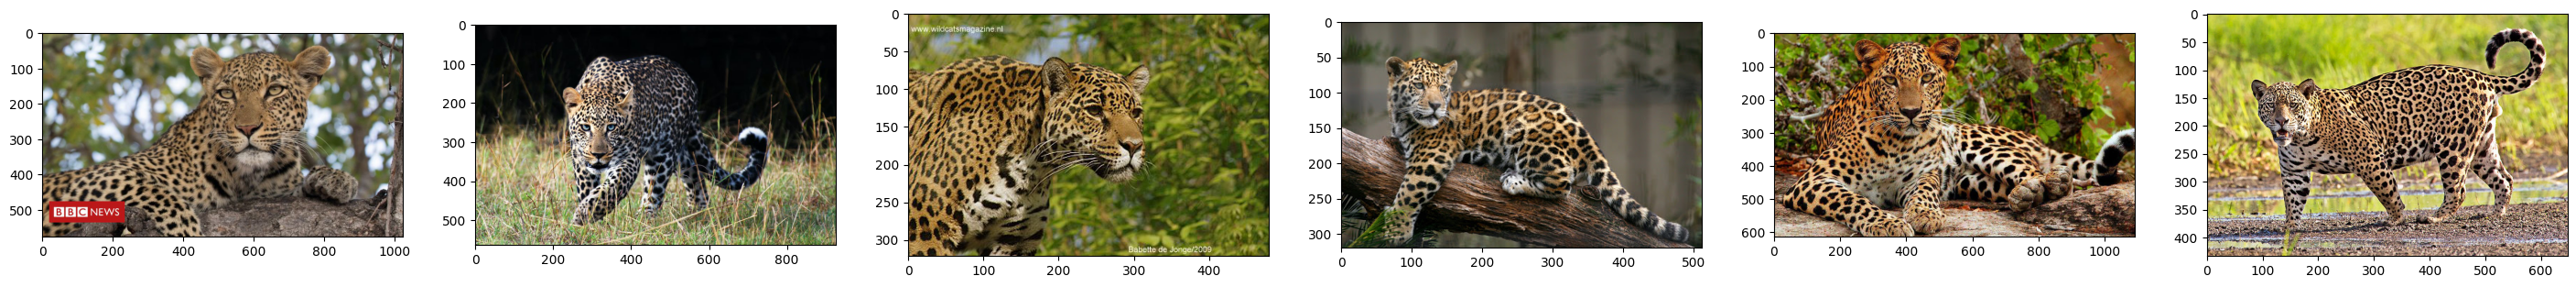

In [ ]:
mpl.style.use('default')
images = pd.DataFrame([file for file in glob.glob("./data/example_data/*.jpg")])
fig=plt.figure(figsize=(60, 60))
for i, file in enumerate(images[0]):
  img = Image.open(file)
  fig.add_subplot(1, 10, i+1)
  plt.imshow(img)

After the test, it is obvious that the model specifically struggles to classify the 'leopard' as it is constantly classified as 'jaguar'. This similarity was not an issue with the from-scratch model for it has not jaguar class to compete with leopard. If results were recalculated ignoring this mass mislabeling problem the result is 0.9352 which is acceptable as a pre-trained model performance. However, in order to actually achieve this accuracy score, the model must be fine-tuned.

In [ ]:
result[result.error == 0].shape[0] / result[result.correct_label != 2].shape[0]

0.9352380952380952

##Re Initializing of Pre-Trained Model

It can be seen that, ignoring leopard problem increases the accuracy significantly. This is a higher accuracy than our from scratch model. In order to actually reach this accuracy, we must fine tune the model. For fine tuning we will follow the steps of official Pytorch [explanation](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb#scrollTo=LmhG7Mj97Of5). Since we use Pytorch library for obtaining pretrained model, this implemantation suits well. We will import the model from the begining setting the grad values false since we will not update all of the weights.

In [ ]:
def initialize_model(num_classes = 4):
    model_ft = models.alexnet(pretrained=True)

    for param in model_ft.parameters():
      param.requires_grad = False

    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    return model_ft, input_size

In [ ]:
model_ft, input_size = initialize_model()
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

##Data Preperation

Just similar to the from scratch model, we define the data in Pytorch Dataloaders. Differently, this time we will normalize the data as specific values ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]). These values are happend to be the mean and std values for ImageNet dataset for every channel of all images. Apart from that, it is the same procedure.

In [ ]:
data_transforms = transforms.Compose([transforms.Resize(input_size), transforms.CenterCrop(input_size), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

partitions = [int(round(len(df) * 0.8 )), int(round(len(df)* 0.1 )), int(round(len(df)* 0.1 ))]

data = custom_dataset(df, transform=data_transforms)

train_set, val_set, test_set = random_split(data, partitions)

dataloaders_dict = {
    'train': DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4),
    'val': DataLoader(val_set, batch_size=8, shuffle=True, num_workers=4)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Finetuning of the Pre-trained Model

Trainer for finetuning. The same training algorithm that suggested by [Pytorch](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) application has been used.

In [ ]:
def fine_train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Fine Training and validation of the pretrained model with using mostly default parameters determines the model. For this application we will not change the parameters as much as the from scratch one since the model already suits these parameters.

In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = fine_train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=False)

Epoch 0/14
----------
train Loss: 0.0946 Acc: 0.9634
val Loss: 0.0720 Acc: 0.9714

Epoch 1/14
----------
train Loss: 0.0256 Acc: 0.9911
val Loss: 0.0658 Acc: 0.9786

Epoch 2/14
----------
train Loss: 0.0049 Acc: 0.9991
val Loss: 0.0527 Acc: 0.9786

Epoch 3/14
----------
train Loss: 0.0032 Acc: 0.9991
val Loss: 0.0829 Acc: 0.9786

Epoch 4/14
----------
train Loss: 0.0026 Acc: 0.9991
val Loss: 0.0671 Acc: 0.9714

Epoch 5/14
----------
train Loss: 0.0050 Acc: 0.9973
val Loss: 0.0560 Acc: 0.9857

Epoch 6/14
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.0565 Acc: 0.9857

Epoch 7/14
----------
train Loss: 0.0016 Acc: 0.9991
val Loss: 0.0670 Acc: 0.9714

Epoch 8/14
----------
train Loss: 0.0050 Acc: 0.9982
val Loss: 0.0538 Acc: 0.9857

Epoch 9/14
----------
train Loss: 0.0036 Acc: 0.9982
val Loss: 0.0788 Acc: 0.9786

Epoch 10/14
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.0599 Acc: 0.9857

Epoch 11/14
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0625 Acc: 0.9857

Ep

##Testing 

0.99 validation accuracy obtained in training phase. This ratio satifies the project goal for pretrained model accuracy. In the next step, test data will be evaluated to obtain a last test result that determines the pretrained models performance.

Data had been splitted in prior steps. For this operation only test datas being used. 


In [ ]:
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4)

In [ ]:
def pre_trained_test(model, dataloader):
  test_result = pd.DataFrame(columns=["correct_label", "prediction", "conf", "prediction_detail", "error"])
  running_corrects = 0
  model.eval()
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

  acc = running_corrects.double() / len(dataloader.dataset)
  print("Test Accuracy:",acc.item())
  return acc.item()

Since an acceptable test accuracy has been obtained from the model, it will be saved for further use.

In [ ]:
result = pre_trained_test(model_ft, test_loader)

Test Accuracy: 0.9642857142857143


In [ ]:
torch.save(model_ft.state_dict(), './finetuned_pretrained_model.pth')